In [12]:
import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import pandas as pd
import calendar as cal
import geocat.comp as gcat


<hr>
Initial Simulations Information
<hr>

In [41]:

#case_desc = np.array(['C6','rC5']) ; pref_out = 'test_'   



cases = np.array(['L32','L48','L58zm2','ne60zm2',]) ; pref_out = 'C6_reg_month_climo_profiles'
cases_desc = np.array(['L32','L48','L58','L58+0.5deg',])

#sim_name = "f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf"
#sim_name = "f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf"
#sim_name = "f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf"

months_clim = np.array(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]) 


line_style = np.array(['solid','solid','solid','solid','solid','solid','dashed','dashed','dashed','dashed','dashed','dashed'])
line_cols = np.array(['limegreen','blue','red','gray','darkorange','darkviolet','limegreen','blue','red','gray','darkorange','darkviolet'])





reg_names = {}
#reg_names['WP'] = ['West Pacific',-10.,10.,120.,150]  # Core of nino precip signal
#reg_names['CP'] = ['Central Pacific',-5.,5.,160,200]       # Core of RWS convergence min.
#reg_names['EP'] = ['East Pacific',0,7.5,200,260]       # Core of RWS convergence min.
reg_names['SP'] = ['SPCZ',-20.,-5.,160.,200]  # Core of W. Pacific signal

var_name = 'OMEGA'; vscale = 1. ;  vname = 'Pressure Velocity (Pa/s)' ; fmin = -0.1 ; fmax = 0.02; afmin = -0.1 ; afmax = 0.02
#var_name = 'ZMDT' ; vscale = 86400. ; vname = 'Deep Convection T Tendency' ; fmin = -5. ; fmax = 5.
#var_name = 'ZMDQ' ; vscale = 1000.*86400. ; vname = 'Deep Convection Q Tendency' ; fmin = -5. ; fmax = 5.
#var_name = 'STEND_CLUBB' ; vscale = 86400./1004. ; vname = 'CLUBB/Turbulence T Tendency' ; fmin = -5. ; fmax = 5.


lobs = False

p_levs = np.arange(100.,1050.,50.)
ppmin = 100. ; ppmax = 1000.





###### DERIVED ######

dir_root = '/glade/p/cgd/amp/people/hannay/amwg/climo/'
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'
dir_proot = '/glade/u/home/rneale/python/'

#sim_names = cam_revert_list()
sim_names = cam_vres_list()
print(sim_names)
reg_df = pd.DataFrame.from_dict(reg_names, orient='index',columns=['long_name','lat_s','lat_n','lon_w','lon_e'])


                                                       run name
C5                                        30L_cam5301_FAMIP.001
C6                              f.e20.FHIST.f09_f09.cesm2_1.001
L48cin5       f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J...
L110                   f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001
L48.BL10        f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111.001
L48.BL10.zm1  f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111_zm...
L48.BL10.zm2  f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111_zm...
L32           f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2....
L48           f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2....
L58           f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_C...
L58zm2        f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_C...
ne60zm2       f.e21.FWscHIST.ne60_L48_BL10_cam6_3_019_plus_C...


<hr>
Main Code
<hr>

Regions plotted -> 
['SP']

Descriptions -> 
['SPCZ']

- Case Name =  L32  -> f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf
  /glade/p/cgd/amp/people/hannay/amwg/climo/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf/0.9x1.25/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf_01_climo.nc
  /glade/p/cgd/amp/people/hannay/amwg/climo/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf/0.9x1.25/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf_12_climo.nc
0   SPCZ   ( -20.0 -5.0 160.0 200 )

- Case Name =  L48  -> f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf
  /glade/p/cgd/amp/people/hannay/amwg/climo/f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf/0.9x1.25/f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf_01_climo.nc
  /glade/p/cgd/amp/people/hannay/amwg/climo/f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf/0.9x1.25/f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf_12_climo.nc
0   SPCZ   ( -20.0 -5.0 160.0 200 )

- Case Name =  

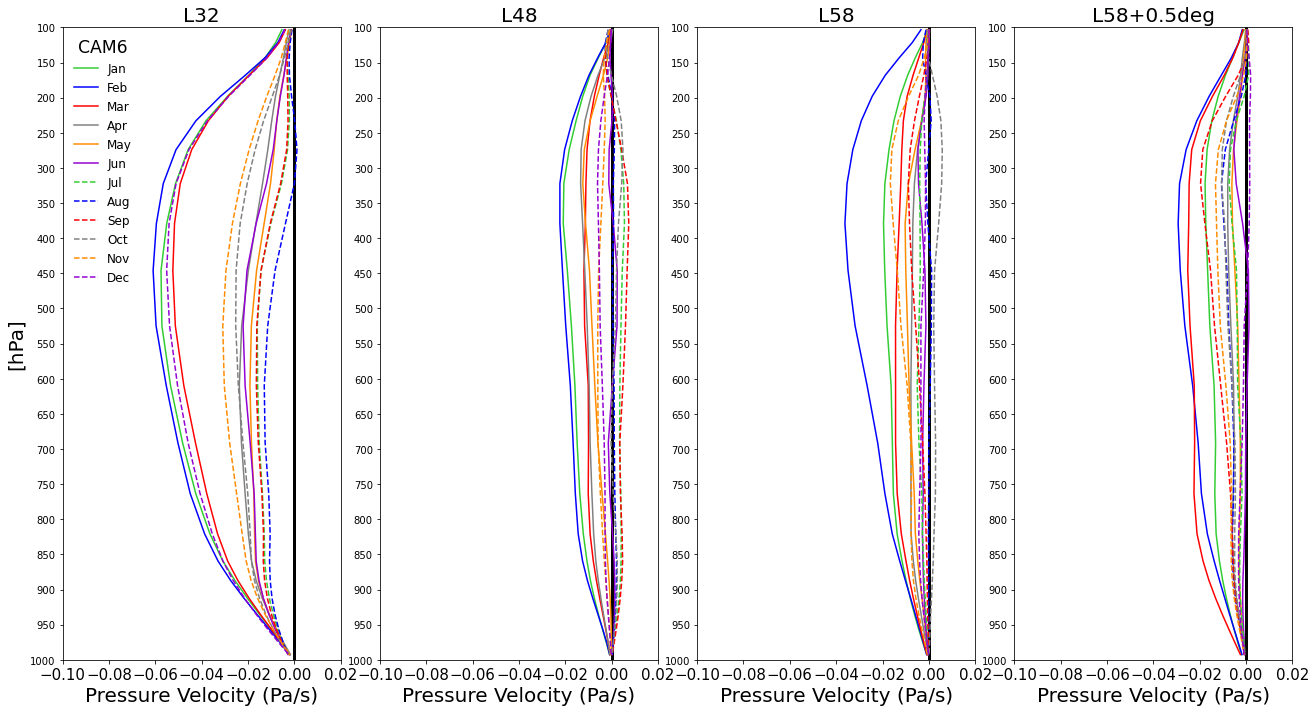

In [42]:
## VARS ##

#case = cases[0]

ncases = len(cases)

nmnths = months_clim.size
nregions = len(reg_names)
regions = np.array(list(reg_names.keys()))

# Format months nums to add to files list
mon_nums = [ "{:02}".format(x+1) for x in range(nmnths) ] # In correct format

print('Regions plotted -> ')
print(regions)
print()
print('Descriptions -> ')
print([reg_df.loc[rreg]['long_name'] for rreg in regions])
 

pletts = ["(a)","(b)","(c)","(d)"] 

## FIGS ##
fig, ax = mp.subplots(1,ncases,figsize=(20, 10))
 
for icase,case in enumerate(cases):
    
   

    ## REGION LOOP ##

    sim_name = sim_names.loc[case]['run name']


    print('')
    print('- Case Name = ',case,' ->',sim_name)



    ### Read files in ###

    #pre_dir = 'yrs_1979-2005' if case=='CE2' else '0.9x1.25'
    pre_dir = '0.9x1.25'

    files_in = [dir_root+sim_name+'/'+pre_dir+'/'+sim_name+'_'+mon_nums[ff]+'_climo.nc' for ff in range(nmnths)]

    print(' ',files_in[0])
    print(' ',files_in[-1])
    files_ptr = xr.open_mfdataset(files_in,parallel=True)

        
    # Grab variable for each plot.

    if var_name != 'DIV':
        var_in = files_ptr[var_name]
    else:
        var_in = files_ptr['OMEGA']
        var_in = var_in.differentiate("lev")

    #ps_in = files_ptr['PS']
    hyam = files_ptr['hyam'] ; hybm = files_ptr['hybm'] ; P0 = 1000. ; lev = files_ptr['lev']

    # Levs
    
#    dp_lev = np.diff(lev)


    for ireg,reg in enumerate(regions):

    ## Set region and var slice

        reg_name = reg_df.loc[reg]['long_name'] 
        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        print(ireg,' ',reg_name,' ','(',reg_s,reg_n,reg_w,reg_e,')')

        var_plot = var_in.loc[:,:,reg_s:reg_n,reg_w:reg_e] # Grab region
        var_plot = vscale*var_plot.mean(dim=['lat','lon'])

        if icase == 0: 
            var_plot_save = var_plot
            ax[icase].set_xlim([fmin,fmax])
        else :
            var_plot = var_plot.interp(lev=var_plot_save.lev)-var_plot_save
            ax[icase].set_xlim([afmin,afmax])

# Levels
        lev = var_plot.lev
        ilevs = np.where(lev >= min(p_levs))
        ilevs = ilevs[0]   

    # Plots

        ax[icase].vlines(0., ppmax, ppmin, linestyle="-",lw=3, color='black')
        for im in range(0,12) :       
            if ireg ==0 : ax[icase].plot(var_plot[im,ilevs],lev[ilevs],lw=1.5,linestyle=line_style[im],color=line_cols[im],label=months_clim[im]) 
            if ireg !=0 : ax[icase].plot(var_plot[im,ilevs],lev[ilevs],lw=1.5,linestyle=line_style[im],color=line_cols[im]) 

        ax[icase].invert_yaxis()    
#        ax[icase].set_title(pletts[ireg]+' '+reg_name,fontsize=20)
        ax[icase].set_title(cases_desc[icase],fontsize=20)
        ax[icase].set_xlabel(vname,fontsize=20) 
        ax[icase].set_yticks(p_levs)
        ax[icase].set_ylim([ppmax,ppmin])
     

        if ireg ==0 : ax[ireg].set_ylabel('[hPa]',fontsize=20) 



mp.rcParams['xtick.labelsize']=15 # GLobal set of xtick label size    

ax[0].legend(loc=0,title='CAM6',fontsize='large',title_fontsize='xx-large',frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.9)      
#    fig.suptitle(case, fontsize=25)


#ax[0].axvline(0.,linestyle='--')
#ax[1].axvline(0.,linestyle='--')  
mp.savefig(dir_proot+'python-figs/vert_proc/'+pref_out+'_'+case+'_'+var_name+'_vprof.png', dpi=150)


In [39]:
#####################################
# CAM6 Revert Experiments + others   
#####################################


def cam_revert_list():
	

    rl = {} # Revert List
# Releases
    rl['C4']   =  ['f40.1979_amip.track1.1deg.001']
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['CC4']  =  ['b40.20th.track1.1deg.012']
    rl['CE1']  =  ['b.e11.B20TRC5CNBDRD.f09_g16.001']
    rl['CE2']  =  ['b.e21.BHIST.f09_g17.CMIP6-historical.001']

    # Reverts
    rl['rC5now']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001']
    rl['rC5']     =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001']
    rl['rC5t']    =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5_param_topo.001']
    rl['rUWold']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.001']
    rl['rGW']    =   ['f.e20.FHIST.f09_f09.cesm2_1_iogw.001']
    rl['rZMc']  =   ['f.e20.FHIST.f09_f09.cesm2_1_capeten.001']
    rl['rMG1']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.001']
    rl['rSB']  =   ['f.e20.FHIST.f09_f09.cesm2_1_sb.002']
    rl['rTMS']  =   ['f.e20.FHIST.f09_f09.cesm2_1_tms.001']
    rl['rCE2i']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revert125.001']
    rl['rC5p']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001']
    rl['rC5pm']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.002']
    rl['rZMp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5_zmconv.001']
    rl['rM3']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mam3.001']
    rl['rUW']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.002']
    rl['rUWp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.003']
    rl['rMG1ii']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.002']
    rl['rice']  =   ['f.e20.FHIST.f09_f09.cesm2_1_ice-micro.001']
    rl['rpfrac']  =   ['f.e20.FHIST.f09_f09.cesm2_1_precip_frac_method.001']
    rl['rpremit']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cld_premit.001']
    rl['rC5psalt']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5seasalt.001']
    rl['rC5pdust']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5dust.001']
    rl['rL30']  =   ['f.e20.FHIST.f09_f09.cesm2_1_L30.001']
    
# SST configs    
    rl['CE2sst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip.001']
    rl['CE2sstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip_daily.001']
    rl['REYsstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_reynolds_daily_sst.006']

    
# High vertical resolution.
    rl['W110']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']
    rl['W121']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_121L_DZ_400m_80kmTop.001']

# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df


In [33]:

def cam_vres_list():
	

    rl = {} # Revert List
# BL Vres
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
#    rl['L48']       =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J.001']
    rl['L48cin5']   =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J_num_cin-5.001']
    rl['L110'] = ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']
#    rl['L48']=['f.e21.FWscHIST.ne30_L48_tag20201111.001']
    rl['L48.BL10']=['f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111.001']
    rl['L48.BL10.zm1']=['f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111_zm1.001']
    rl['L48.BL10.zm2']=['f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111_zm2.001']
    rl['L32']  = ['f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf']
    rl['L48']  = ['f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf']
    rl['L58']  = ['f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf']
    rl['L58zm2']  = ['f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2.hf']
    rl['ne60zm2']  = ['f.e21.FWscHIST.ne60_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2.hf']
    
    
# Data frame
    rl_df = pd.DataFrame.from_dict(rl,columns=['run name'],orient='index',dtype='object')
    
    return rl_df
    